#### Cyber Bully Text Detector

Disclaimer; there are parts of code that have been made markdown type since those models werent used in the final run and top 3 were chosen only. 
In order to run the following models make the cell "code" for Bag of words using TF IDF and turn CV cell to markdown
1. Multinomial Naïve Bayes 
2. XGBOOST
* the above two models are actually 'markdown version' in the final submission since we didnt use them


In order to run the following models make the cell "code" for Bag of words using CV and turn TF IDF cell to markdown
1. Gaussian Naive bayes
2. SVM
3. Random Forest

In [1]:
#install this in terminal before running the code
#brew install libomp

#Load packages
import nltk
nltk.download('wordnet')
import re
import pandas as pd
import numpy as np
import string

#Text Preprocessing
import string
from collections import defaultdict
from collections import  Counter
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize 


#model training
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
#!pip install xgboost
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import hstack

# Classification Models and Success metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amenashahid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amenashahid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### reading the data from the folder

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df=df.reindex(columns=['Comment', 'Insult'])

In [4]:
## Get the Independent Features
X=df.iloc[:,:-1]
## Get the dependent Features
Y=df.iloc[:,-1]

In [5]:
X.shape,Y.shape

((3947, 1), (3947,))

In [6]:
X.head()

,Comment
0,"""You fuck your dad."""
1,"""i really don't understand your point.\xa0 It ..."
2,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,"""listen if you dont wanna get married to a man..."
4,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


# Text Preprocessing

Here we try to clean the data and remove unnecessary details

The commented code is basically where we tried it both ways, by keeping certain features and by removing certain techniques and finally ended up with what was better

#### Details on Lemmatization 
It is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.
Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

We will run the model with punctuations and without punctuations and see which one gives better results since as per our analysis on the raw data, punctuations count can actually help in certain cases to recognize the insult better.

### Future Scope of Cleaning and Pre processing

#### Spell check using text blob  
from textblob import TextBlob
df['text_rare'].apply(lambda x: str(TextBlob(x).correct()))

from emot.emo_unicode import UNICODE_EMO, EMOTICONS
#### Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        return text
#### Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        return text


In [7]:
stopword_set = nltk.corpus.stopwords.words('english')
wordnet = WordNetLemmatizer()

In [8]:
#Remove urls, html, punctuation
def preProcess(iter):
    
        
        # remove extra space
        regex_ws=re.compile("\s+")
        ret=regex_ws.sub(" ",iter)
        ret=ret.replace("&amp;","&").replace("&lt;","<").replace("&gt;",">").replace("\\x"," ")
        #text="".join([word for word in text if word not in string.punctuation])
        
        #Replace URL
        regexp="(https?:\/\/(?:www\.|(?!www)|(?:xmlns\.))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
        ret=re.sub(regexp,"url",ret)
        
        #replace @addresses
        regexp='@[A-z0-9_]+'
        ret=re.sub(regexp,"@refertoperson",ret)
        
        #replace anything other than lower/upper  alphabets with space (number will be excluded as well)
        regexp='[^a-zA-z]'
        ret=re.sub(regexp,' ',ret)
        
        #Bring everything to lowercase
        ret=ret.lower()

        #Split on punctuations
        #ret1=word_tokenize(ret)        
        ret1=re.split(" ",ret)
        
        
        #lemmatize
        ret2=[wordnet.lemmatize(word) for word in ret1 if word not in stopword_set]
        ret2=" ".join(ret2)
        
        #Remove Stopwords
        ret2=[word for word in ret1 if word not in stopword_set]
        ret2=" ".join(ret2)
        
        #removing punctuations 
        #ret2="".join([char for char in ret2 if char not in string.punctuation])

        return ret2

In [9]:
df['body_text_nostop']=df['Comment'].apply(lambda x: preProcess(x.lower()))
train_text = df['body_text_nostop']


In [10]:
df.head(5)


,Comment,Insult,body_text_nostop
0,"""You fuck your dad.""",1,fuck dad
1,"""i really don't understand your point.\xa0 It ...",0,really understand point seems mixing apples...
2,"""A\\xc2\\xa0majority of Canadians can and has ...",0,a\ c \ majority canadians wrong \\n\\nunless ...
3,"""listen if you dont wanna get married to a man...",0,listen dont wanna get married man women dont ...
4,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...",0,c e c b\u ea n xu\u ed ng \u \u b \u eddn...


## Data Visualizations

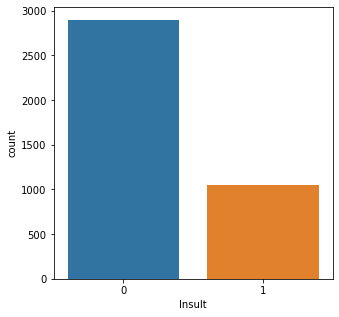

In [11]:
plt.figure(figsize = (5, 5))
sns.countplot(x = "Insult", data = df)

#### Graphical Pie chart representation of data

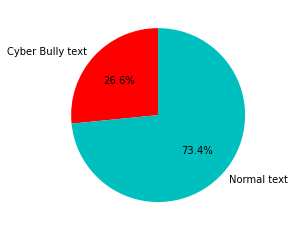

In [12]:
#%age split of insults to non insults
piechart = [len(df[df['Insult']==1]),len(df[df['Insult']==0])]
activities = ['Cyber Bully text', 'Normal text']
colors = ['r', 'c']
plt.pie(piechart, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

#### WordCloud

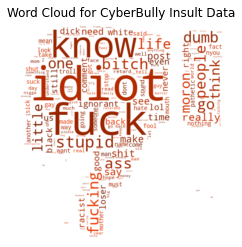

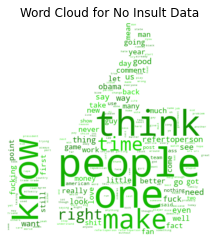

In [13]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 14
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

imgmask=np.array(Image.open('hand1.jpg').rotate(180))

allwords=" ".join( [x for x in df[df['Insult']==1]['body_text_nostop']] )
wordCloud=WordCloud(mask=imgmask, width=500,height=300,random_state=20,max_font_size=110,background_color='white').generate(allwords)
#change the color setting
wordCloud.recolor(color_func = random_color_func)
plt.imshow(wordCloud,interpolation='bilinear')
plt.title('Word Cloud for CyberBully Insult Data')
plt.axis('off')
plt.show()


def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 114
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

imgmask=np.array(Image.open('hand1.jpg'))
allwords=" ".join( [x for x in df[df['Insult']==0]['body_text_nostop']] )
wordCloud=WordCloud(mask=imgmask,width=500,height=300,random_state=20,max_font_size=110,background_color='white').generate(allwords)
#change the color setting
wordCloud.recolor(color_func = random_color_func)
plt.imshow(wordCloud,interpolation='bilinear')
plt.title('Word Cloud for No Insult Data')
plt.axis('off')
plt.show()


#### Adding features in the dataset

In [14]:
df['text_length']=df.Comment.map(lambda x:len(x))
df['word_count']=df.Comment.str.split().map(lambda x:len(x))
df['unique_word_count']=df.Comment.map(lambda x:len(set(str(x).split())))
df['mean_word_length']=df.Comment.map(lambda x:np.mean([len(w) for w in str(x).split()]))
import string
df['punctuation_count']=df.Comment.map(lambda x:len([c for c in str(x) if c in string.punctuation]))


#### More visualizations

In [15]:
def plotbars(feature):
    plt.figure(figsize = (4, 4))
    xyz=df.groupby(['Insult'])[feature].describe()[['mean']]
    pd.pivot_table(xyz, values ='mean', index = 'Insult', columns = 'Insult').plot.bar()
    plt.ylabel('Mean {}'.format(feature) )
    plt.xticks(rotation=0)
    plt.title('Mean {} Comparison'.format(feature),fontsize=14 )#fontweight='bold',color='blue'

<Figure size 288x288 with 0 Axes>

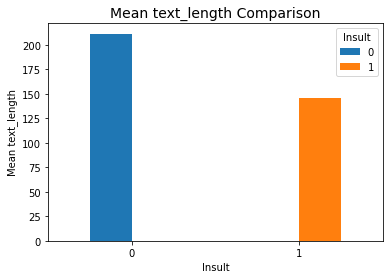

<Figure size 288x288 with 0 Axes>

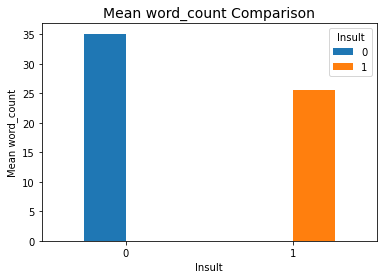

<Figure size 288x288 with 0 Axes>

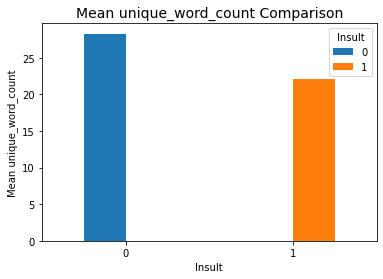

<Figure size 288x288 with 0 Axes>

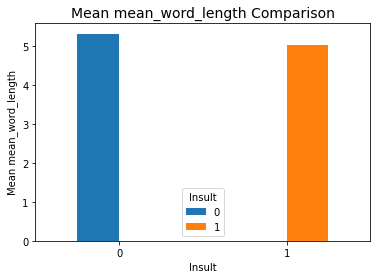

<Figure size 288x288 with 0 Axes>

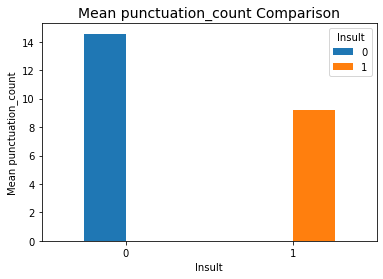

In [16]:
plotbars('text_length')
plotbars('word_count')
plotbars('unique_word_count')
plotbars('mean_word_length')
plotbars('punctuation_count')


#### Results:
As per the above graphs, text length, word count and punctuation count is usually higher in non insult text. Using this can help our analysis

### Bag of Words using Term frequency TF IDF
the cell below needs to be turned to 'code' if running multinomial naive bayes and XG boost models (for best results)

# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    norm='l2',
    min_df=0,
    smooth_idf=False,preprocessor=preProcess,
    max_features=3000)
char_vectorizer.fit(train_text)
#transformation using TF IDF
train_char_features = char_vectorizer.transform(train_text)
print('Shape of features:  ' ,train_char_features.shape)
#sparse matrix
X_Tfidf_df=pd.DataFrame(train_char_features.toarray())
#assigning the right column names 
X_Tfidf_df.columns = char_vectorizer.get_feature_names()
X_Tfidf_df.head()
#assigning features to X
X=X_Tfidf_df
#assigning labels to Y
y=df['Insult']
#checking the shape 
print(X.shape,"   ",y.shape)

In [17]:
X.head()

,Comment
0,"""You fuck your dad."""
1,"""i really don't understand your point.\xa0 It ..."
2,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,"""listen if you dont wanna get married to a man..."
4,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


### Bag Of Words using Count Vectorizer

associate index to each word in a vocabulary in a sparse matrix – each has a length of the length equal to count of all unique words in data - each word as a result is given a flag of 1/0
since it creates a sparse vector, change it to the dense vector – increases the features 

** the cell below needs to be turned to 'code' when checking the SVM, Random Forest and Gaussian Naive Bayes. and it needs to be turned to 'markdown' when running the 'Multinomial Naive Bayes and XG Boost model

In [18]:
train_text = df['body_text_nostop']

from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000,analyzer='word', ngram_range=(2, 6))
X_CVector=pd.DataFrame(cv.fit_transform(train_text).toarray())
#assigning the right column names 
X_CVector.columns = cv.get_feature_names()
X_CVector.head()
#assigning features to X
X=X_CVector
#assigning labels to Y
y=df['Insult']
#checking the shape 
print("shapes of X and y:  ",X.shape,"   ",y.shape)



shapes of X and y:   (3947, 3000)     (3947,)


#### adding extra numerical features

Since our model performed better without the extra features, i have made the cell below a mark down cell

X['text_length']=df['text_length']
X['word_count']=df['word_count']
X['unique_word_count']=df['unique_word_count']
X['punctuation_count']=df['punctuation_count']

# Train_Test Split

creating 30% split for test size and remaining for training
stratifying based on Y (insult 0/1)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state =5)


#### Using SMOTE to oversample minority data to achieve more balanced data set

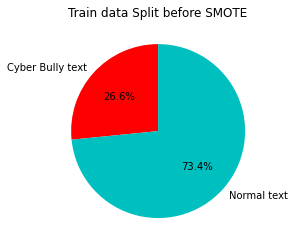

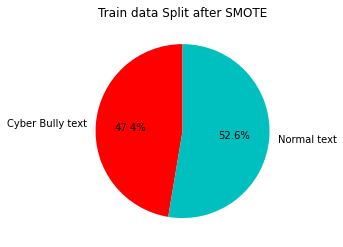

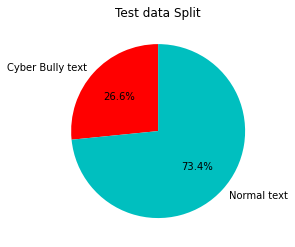

In [20]:
#%age split of insults to non insults
y_train=y_train.to_frame()
y_test=y_test.to_frame()

piechart = [len(y_train[y_train['Insult']==1]),len(y_train[y_train['Insult']==0])]
activities = ['Cyber Bully text', 'Normal text']
colors = ['r', 'c']
plt.pie(piechart, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.title('Train data Split before SMOTE')
plt.show()

#sudo pip install imbalanced-learn (install using this in terminal)
import imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.9)
x_train, y_train = smote.fit_sample(x_train, y_train)

#%age split of insults to non insults
piechart = [len(y_train[y_train['Insult']==1]),len(y_train[y_train['Insult']==0])]
activities = ['Cyber Bully text', 'Normal text']
colors = ['r', 'c']
plt.pie(piechart, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.title('Train data Split after SMOTE')
plt.show()

piechart = [len(y_test[y_test['Insult']==1]),len(y_test[y_test['Insult']==0])]
activities = ['Cyber Bully text', 'Normal text']
colors = ['r', 'c']
plt.pie(piechart, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.title('Test data Split')
plt.show()


#### Scaling the numerical features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_cols=['text_length','word_count' ,'unique_word_count','punctuation_count' ]
standardized_numeric_data = scaler.fit_transform(x_train[num_cols])
x_train = np.concatenate((standardized_numeric_data,np.array(x_train.drop(columns=num_cols))),axis=1)

standardized_numeric_data = scaler.fit_transform(x_test[num_cols])
x_test = np.concatenate((standardized_numeric_data,np.array(x_test.drop(columns=num_cols))),axis=1)


#### functions to plot learning curve and models + evaluations

In [21]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, scoring='recall',
                        n_jobs=None,shuffle = None,train_sizes=np.linspace(.1, 1.0, 10)):
    import matplotlib.pyplot as plt
    plt.title(title)
    
    plt.xlabel("Training examples")
    plt.ylabel("Recall Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, scoring=scoring,cv=cv, n_jobs=n_jobs, 
                       train_sizes=train_sizes,shuffle = True,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plt,train_sizes, train_scores, test_scores, fit_times


def model(classifier, train_feat, test_feat, train_label, test_label,abc):
    m1=classifier.fit(train_feat, train_label)  
    if abc==0:
        print('\n **** TRAIN SCORES **** \n')
        predict_y = classifier.predict(train_feat)
        accuracy = accuracy_score(train_label, predict_y)
        precision = precision_score(train_label, predict_y)
        recall = recall_score(train_label, predict_y)
        f1score=f1_score(train_label, predict_y)
        conf_matrix = confusion_matrix(train_label, predict_y)
        print('\nAccuracy_score: {:.3f}'.format(accuracy ))
        print('precision_score: {:.3f}'.format(precision.mean()))
        print('recall_score: {:.3f}'.format(recall.mean()))
        print('f1_score: {:.3f}'.format(f1score.mean()))
        print('\nconfusion_matrix: \n')
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4, 2))
        plt.title('Confusion Matrix')
        sns.heatmap(conf_matrix,annot=True, fmt='g')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()
        import matplotlib.pyplot as plt
        plt,train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(m1,classifier,train_feat, train_label, cv = 3,scoring = 'f1_weighted')
        plt.show()

    
    print('\n **** TEST SCORES **** \n')
    predict_y = classifier.predict(test_feat)
    accuracy = accuracy_score(test_label, predict_y)
    precision = precision_score(test_label, predict_y)
    recall = recall_score(test_label, predict_y)
    f1score=f1_score(test_label, predict_y)
    conf_matrix = confusion_matrix(test_label, predict_y)
    print('\nAccuracy_score: {:.3f}'.format(accuracy ))
    print('precision_score: {:.3f}'.format(precision.mean()))
    print('recall_score: {:.3f}'.format(recall.mean()))
    print('f1_score: {:.3f}'.format(f1score.mean()))
    print('\nconfusion_matrix: \n')
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 2))
    plt.title('Confusion Matrix')
    sns.heatmap(conf_matrix,annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    #print(classification_report(valid_y, classifier.predict(valid_vector)))
    return

### MultiNomial Naive Bayes

 multinomial naive bayes since it goes well with the sequential text related data


 **** TRAIN SCORES **** 


Accuracy_score: 0.610
precision_score: 0.734
recall_score: 0.278
f1_score: 0.403

confusion_matrix: 



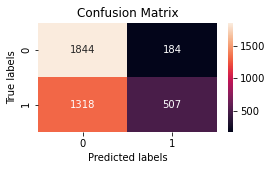

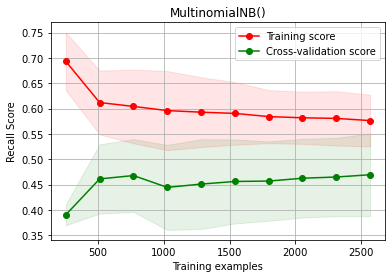


 **** TEST SCORES **** 


Accuracy_score: 0.673
precision_score: 0.385
recall_score: 0.387
f1_score: 0.386

confusion_matrix: 



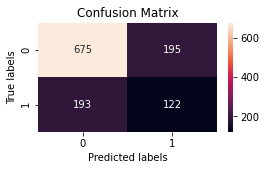

In [22]:
from sklearn.naive_bayes import MultinomialNB
model(MultinomialNB(),x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)

### Gaussian Naive Bayes


 **** TRAIN SCORES **** 


Accuracy_score: 0.683
precision_score: 0.599
recall_score: 1.000
f1_score: 0.749

confusion_matrix: 



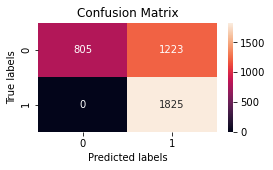

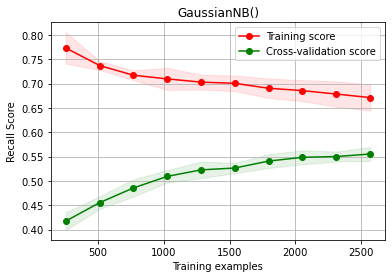


 **** TEST SCORES **** 


Accuracy_score: 0.430
precision_score: 0.291
recall_score: 0.794
f1_score: 0.426

confusion_matrix: 



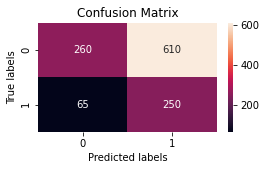

In [23]:
from sklearn.naive_bayes import GaussianNB
model(GaussianNB(),x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)


### XGBoost classifier
Reason: its an ensemble and it classifies very well when compared to decision trees, logistics and random forest


 **** TRAIN SCORES **** 


Accuracy_score: 0.579
precision_score: 0.868
recall_score: 0.130
f1_score: 0.226

confusion_matrix: 



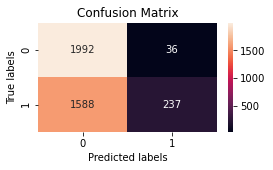

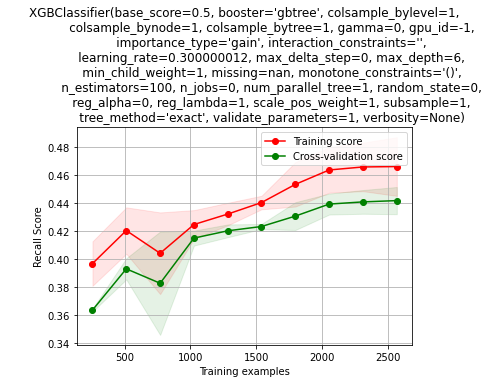


 **** TEST SCORES **** 


Accuracy_score: 0.746
precision_score: 0.617
recall_score: 0.117
f1_score: 0.197

confusion_matrix: 



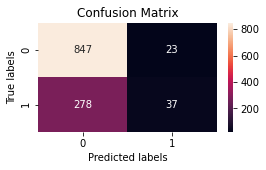

In [24]:
from xgboost import XGBClassifier
model(XGBClassifier(), x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)


#### SVC Classifier


 **** TRAIN SCORES **** 


Accuracy_score: 0.636
precision_score: 0.570
recall_score: 0.935
f1_score: 0.709

confusion_matrix: 



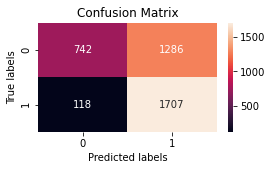

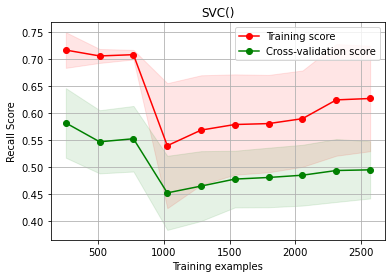


 **** TEST SCORES **** 


Accuracy_score: 0.406
precision_score: 0.275
recall_score: 0.756
f1_score: 0.403

confusion_matrix: 



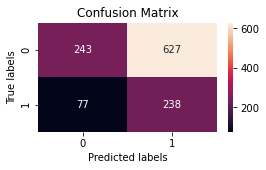

In [25]:
from sklearn.svm import SVC
model(SVC(), x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)


#### SVM with hyperparameters


 **** TRAIN SCORES **** 


Accuracy_score: 0.723
precision_score: 0.633
recall_score: 0.987
f1_score: 0.772

confusion_matrix: 



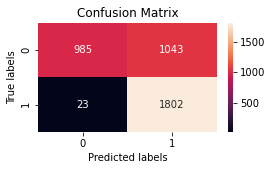

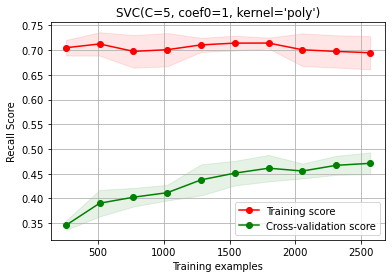


 **** TEST SCORES **** 


Accuracy_score: 0.407
precision_score: 0.282
recall_score: 0.797
f1_score: 0.417

confusion_matrix: 



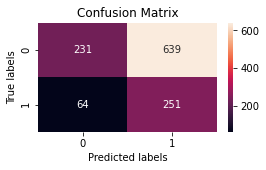

In [26]:
model(SVC(kernel="poly", degree=3, coef0=1, C=5), x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)

#### Random Forest Classifier


 **** TRAIN SCORES **** 


Accuracy_score: 0.727
precision_score: 0.636
recall_score: 0.988
f1_score: 0.774

confusion_matrix: 



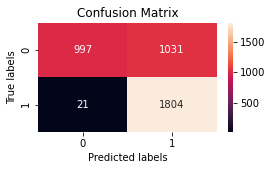

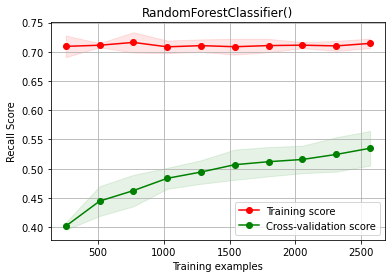


 **** TEST SCORES **** 


Accuracy_score: 0.430
precision_score: 0.289
recall_score: 0.784
f1_score: 0.422

confusion_matrix: 



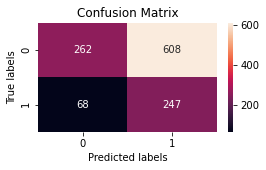

In [27]:
from sklearn.ensemble import RandomForestClassifier
model(RandomForestClassifier(), x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)


#### Random forest hyper parameter tuning


 **** TRAIN SCORES **** 


Accuracy_score: 0.727
precision_score: 0.637
recall_score: 0.985
f1_score: 0.774

confusion_matrix: 



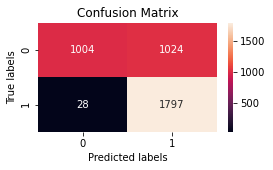

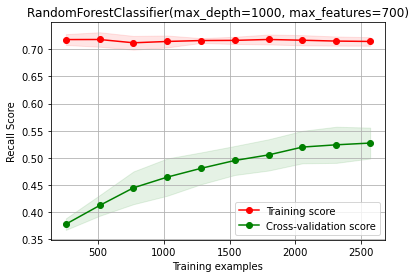


 **** TEST SCORES **** 


Accuracy_score: 0.421
precision_score: 0.284
recall_score: 0.775
f1_score: 0.416

confusion_matrix: 



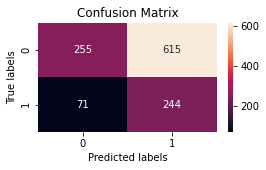

In [28]:
from sklearn.ensemble import RandomForestClassifier #random_state=60,n_estimators=50,min_samples_split=100
model(RandomForestClassifier(max_depth=1000,max_features=700), x_train, x_test, y_train.values.ravel(),y_test.values.ravel(),0)


# Let us try with New set of data points that the model has not seen before

In [29]:
newdata=pd.read_csv('test_with_solutions.csv')
newdata=newdata.reindex(columns=['Comment', 'Insult'])
Xnew=newdata.iloc[:,:-1]
Ynew=newdata.iloc[:,-1]

#data shape
print(Xnew.shape,"  ",Ynew.shape)

(2647, 1)    (2647,)


### Preprocessing , Data Cleaning 

In [30]:
newdata['body_text_nostop']=newdata['Comment'].apply(lambda x: preProcess(x.lower()))
#print(newdata.head())
train_text_newdata = newdata['body_text_nostop']

### Visualization on Unseen Data

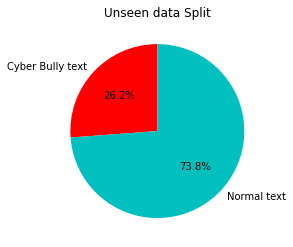

In [31]:
piechart = [len(newdata[newdata['Insult']==1]),len(newdata[newdata['Insult']==0])]
activities = ['Cyber Bully text', 'Normal text']
colors = ['r', 'c']
plt.pie(piechart, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.title('Unseen data Split')
plt.show()


### Bag of words using Count Vectorizer

In [32]:
X_CVector_newdata=pd.DataFrame(cv.transform(train_text_newdata).toarray())
X_CVector_newdata.columns = cv.get_feature_names()
Xnewdata=X_CVector_newdata
ynewdata=newdata['Insult']

#### Gaussian Naive Bayes on Unseen Test set


 **** TEST SCORES **** 


Accuracy_score: 0.383
precision_score: 0.285
recall_score: 0.898
f1_score: 0.432

confusion_matrix: 



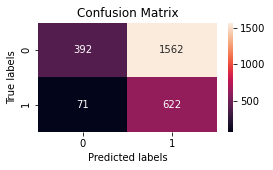

In [33]:
from sklearn.naive_bayes import GaussianNB
model(GaussianNB(),X, Xnewdata, y.values.ravel(),ynewdata.values.ravel(),1)
